#### Loading data

In [4]:
suppressPackageStartupMessages(library(TreeSummarizedExperiment))
quantDir <- "/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=2:6/post_type=gibbs_nrep=100_tf=100/salmon_quants"
saveDir <- "../../environment/brain_sim_normal"
samples <- as.vector(outer(c(1:6), c(1,2), function(x,y) paste(x,y,sep="_")))
                           
files <- file.path(quantDir, samples, "quant.sf")
coldata <- data.frame(files = files, names = samples, condition = as.factor(rep(c(1,2),each=6)))
clustFile <- "/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=2:6/post_type=gibbs_nrep=100_tf=100/terminus/no_threshold0/cluster_nwk.txt"
tseCons <- beaveR::buildTSE(treeTermFile = clustFile, coldata = coldata)
treeCons <- rowTree(tseCons)
l <- length(treeCons$tip)
termFile <- "/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=2:6/post_type=gibbs_nrep=100_tf=100/terminus/old/1_1/clusters.txt"

reading tree

importing quantifications

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


found matching transcriptome:
[ GENCODE - Homo sapiens - release 26 ]

loading existing TxDb created: 2023-03-02 17:08:07

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

loading existing transcript ranges created: 2023-03-02 21:45:10

Missing txps 3817

Aggregation Started

Aggregation Ended



#### Loading True counts

In [7]:
load("/fs/cbcb-scratch/jfan03/treeterm-paper/output/seed=1_fc=2:6/sim_expr.rda")
suppressPackageStartupMessages(source("../../tree_helper.R"))
saveDir <- "../../environment/brain_sim_normal"
suppressPackageStartupMessages(library(TreeSummarizedExperiment))

missingTxps <- setdiff(treeCons$tip.label, rownames(sim.counts.mat))
dts <- Reduce(union, c(names(iso.dge)[iso.dge], names(iso.dte)[iso.dte], names(iso.dte.only)[iso.dte.only], 
                       names(iso.dtu)[iso.dtu]))
dts <- intersect(dts, rownames(sim.counts.mat))
sim.counts.mat <- rbind(sim.counts.mat, matrix(0, nrow = length(missingTxps), ncol = ncol(sim.counts.mat),
                                               dimnames = list(missingTxps, colnames(sim.counts.mat))))
sim.counts.mat <- sim.counts.mat[treeCons$tip.label,]
dts <- intersect(dts, rownames(sim.counts.mat))

l <- length(treeCons$tip)
innNodes <- l+1:treeCons$Nnode
aggCountsNodes <- computeAggNodes(treeCons, c(1:length(treeCons$tip),innNodes), sim.counts.mat)
logFCNodes <- ifelse(rowSums(aggCountsNodes)==0, 0, log2(aggCountsNodes[,2]+1)-log2(aggCountsNodes[,1]+1))
names(logFCNodes)[(l+1):length(logFCNodes)] <- paste("Node", names(logFCNodes)[(l+1):length(logFCNodes)], sep="")
rootFC <- abs(logFCNodes[l+1])

#### Gene

In [4]:
gse <- tximeta::summarizeToGene(tseCons[1:l,])

loading existing TxDb created: 2023-03-02 17:08:07

obtaining transcript-to-gene mapping from database

loading existing gene ranges created: 2023-03-02 17:08:18

gene ranges assigned by total range of isoforms, see `assignRanges`

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



#### Terminus

In [8]:
suppressPackageStartupMessages(source("../../terminus_helper.R"))
yTermThrNS <- tseCons[1:l,]
groupsClust <- parseClustFile(termFile, yTermThrNS)
mInds <- seq(nrow(yTermThrNS) + length(groupsClust))
aggCountsTerm <- computeTermAggNodes(groupsClust, mInds, sim.counts.mat)
logFCNodesTerm <- ifelse(rowSums(aggCountsTerm)==0, 0, log2(aggCountsTerm[,2]+1)-log2(aggCountsTerm[,1]+1))

#### Loading features

In [2]:
load(file.path(saveDir, "detNodes.RData"))
load(file.path(saveDir, "negNodes.RData"))

#### Computing Metrics

In [16]:
suppressPackageStartupMessages(source("../../tree_helper.R"))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(ggplot2))

In [17]:
df <- data.frame(Method=character(), Metric=character(), FDR_0.01 = numeric(), FDR_0.05 = numeric(), FDR_0.10 = numeric())
for(n in names(detNodes))
{    
    if(!(n %in% c("Terminus","Genes"))) {
       stats <-  sapply(seq_along(detNodes[[n]]), function(i) computeMetOut(detNodes[[n]][[i]], logFCNodes, tree = treeCons, negNodes = negNodes[[n]][[i]], lfcThresh = rootFC))     
    }
    else if (n=="Terminus") {
        stats <-  sapply(seq_along(detNodes[[n]]), function(i) computeMetOut(detNodes[[n]][[i]], 
                logFCNodesTerm, tree = NULL, negNodes = negNodes[[n]][[i]], lfcThresh = rootFC))
    }
   else {
       dg <- union(dge.genes, c(dte.genes, dtu.genes))
       dg <- intersect(dg, rownames(gse))
       tG <- match(dg, rownames(gse))
       stats <- sapply(detNodes[[n]], function(genes) {
        computeTPFP(tG, genes, seq(nrow(gse)), seq(nrow(gse)))
        })
   }
    for(i in seq(ncol(stats)))
        stats[,i] <- round(unlist(stats[,i]),3)
#         stats[,i] <- unlist(stats[,i])
#     print(stats)
    colnames(stats) <- colnames(df)[c(3:5)]
    stats <- cbind(Method=rep(n,2), Metric = c("FDR", "TPR"), stats)
    df <- rbind(df, stats)
}
for(i in seq(ncol(df))) {
    if (i <=2) {
        df[,i] <- as.character(unlist(df[,i]))
    }
    else {
        df[,i] <- as.numeric(unlist(df[,i]))
    }
}
dfA <- df %>% pivot_wider(names_from = Metric, values_from = c(3:5))
dfA <- dfA[,c(1,seq(2,7,2),seq(3,7,2))]
dfA <- dfA %>% 
    mutate(keep_0.01=ifelse(FDR_0.01_FDR <= 0.01, T, F)) %>%
    mutate(keep_0.05=ifelse(FDR_0.05_FDR <= 0.05, T, F)) %>%
    mutate(keep_0.10=ifelse(FDR_0.10_FDR <= 0.10, T, F))

In [85]:
df1 <- dfA %>% 
  pivot_longer(starts_with("FDR"),
  names_to = c("fdr", ".value"),
  names_pattern = "(.+)_(.+)"
  ) %>% select(fdr, FDR, TPR, Method)
df2 <- dfA %>% pivot_longer(starts_with("keep"), 
                    names_to = c(".value", "fdr"),
                    names_sep="_") %>% select(keep)
dfC <- bind_cols(df1, df2)
dfC$FDR <- unlist(dfC$FDR)
dfC$TPR <- unlist(dfC$TPR)
dfC$Method <- unlist(dfC$Method)
dfC$Meth2 <- ifelse(dfC$keep, dfC$Method, NA)

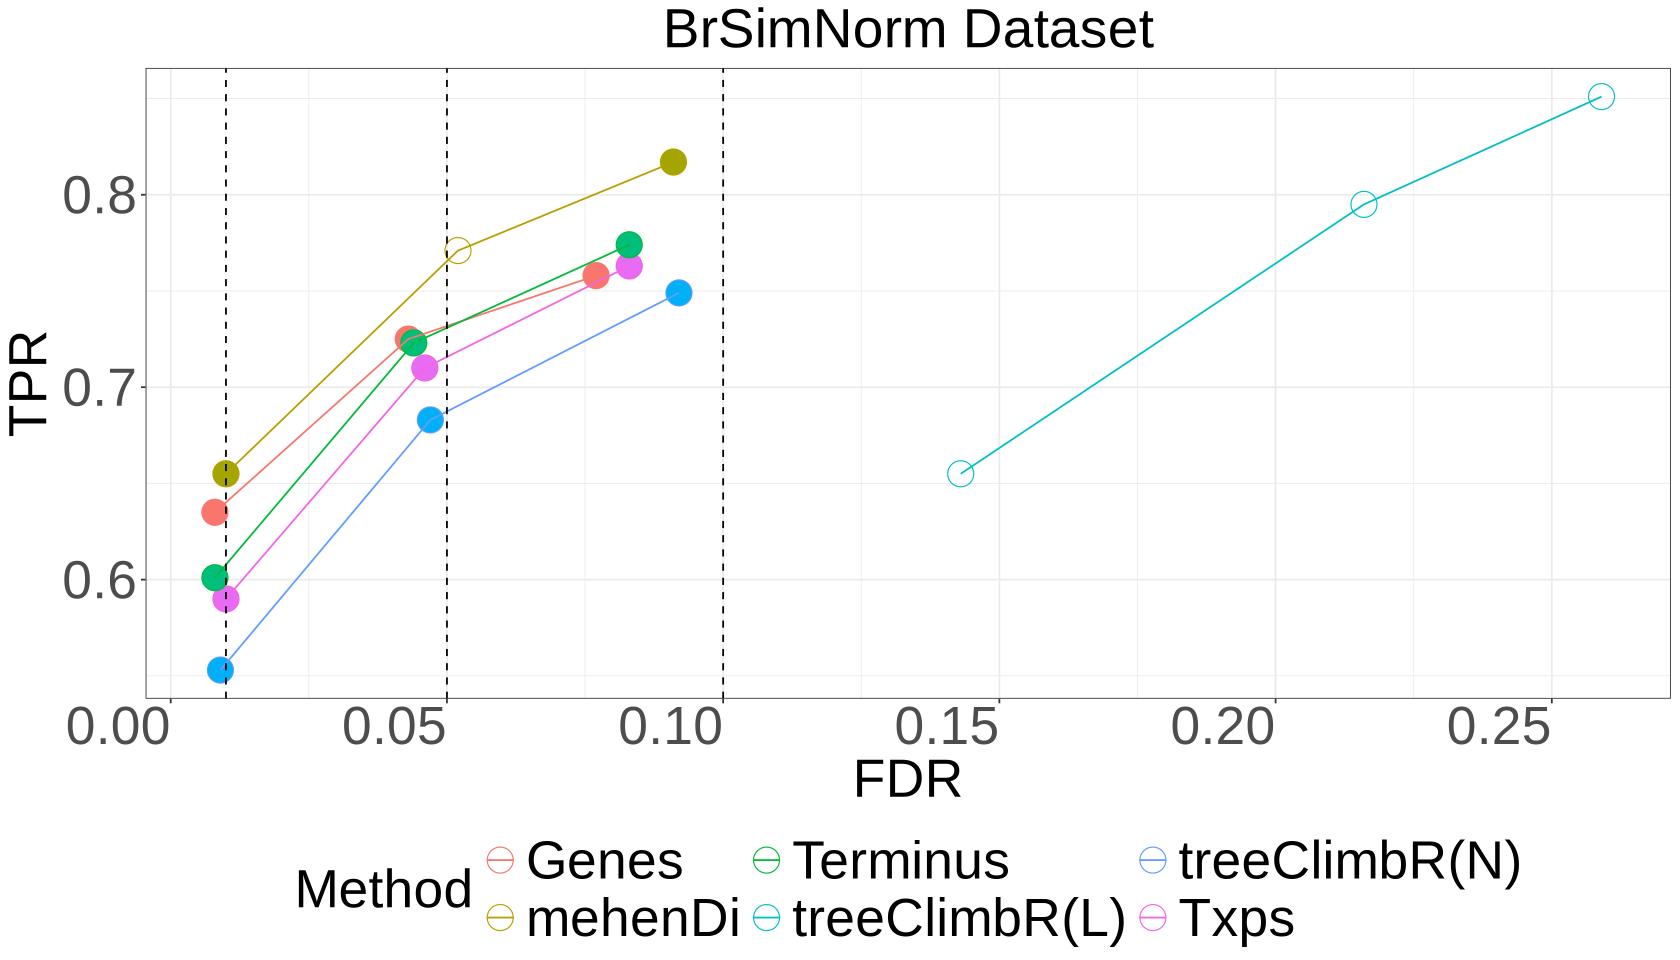

In [105]:
options(repr.plot.width=14, repr.plot.height=8)
size <- 32
pBrSimNorm <- ggplot(dfC, aes(x = FDR, y = TPR, 
                             color = Method
                             )) + 
                geom_point(size=7,shape=21, aes(fill = Meth2)) + 
                scale_fill_discrete(na.value = "transparent") +
                geom_line() +
                theme_bw() +
                geom_vline(xintercept = c(0.01, 0.05, 0.1), linetype = "dashed") +
                ggtitle("BrSimNorm Dataset") +
                theme(axis.title = element_text(size = size),
                plot.title = element_text(size = size + 1, hjust=0.5),
                axis.text = element_text(size = size),
                legend.text = element_text(size = size),
                legend.title = element_text(size = size),
                legend.position = "bottom") +
                scale_x_continuous(breaks = seq(0,0.35,0.05)) +
                guides(fill = "none") + 
#                 scale_fill_manual(values=scales::hue_pal()(6))
                labs(fill="Method") +
                theme(axis.text.x = element_text(hjust = 1))
                
pBrSimNorm

In [100]:
scales::hue_pal()(6)


[1] "#F8766D" "#B79F00" "#00BA38" "#00BFC4" "#619CFF" "#F564E3"

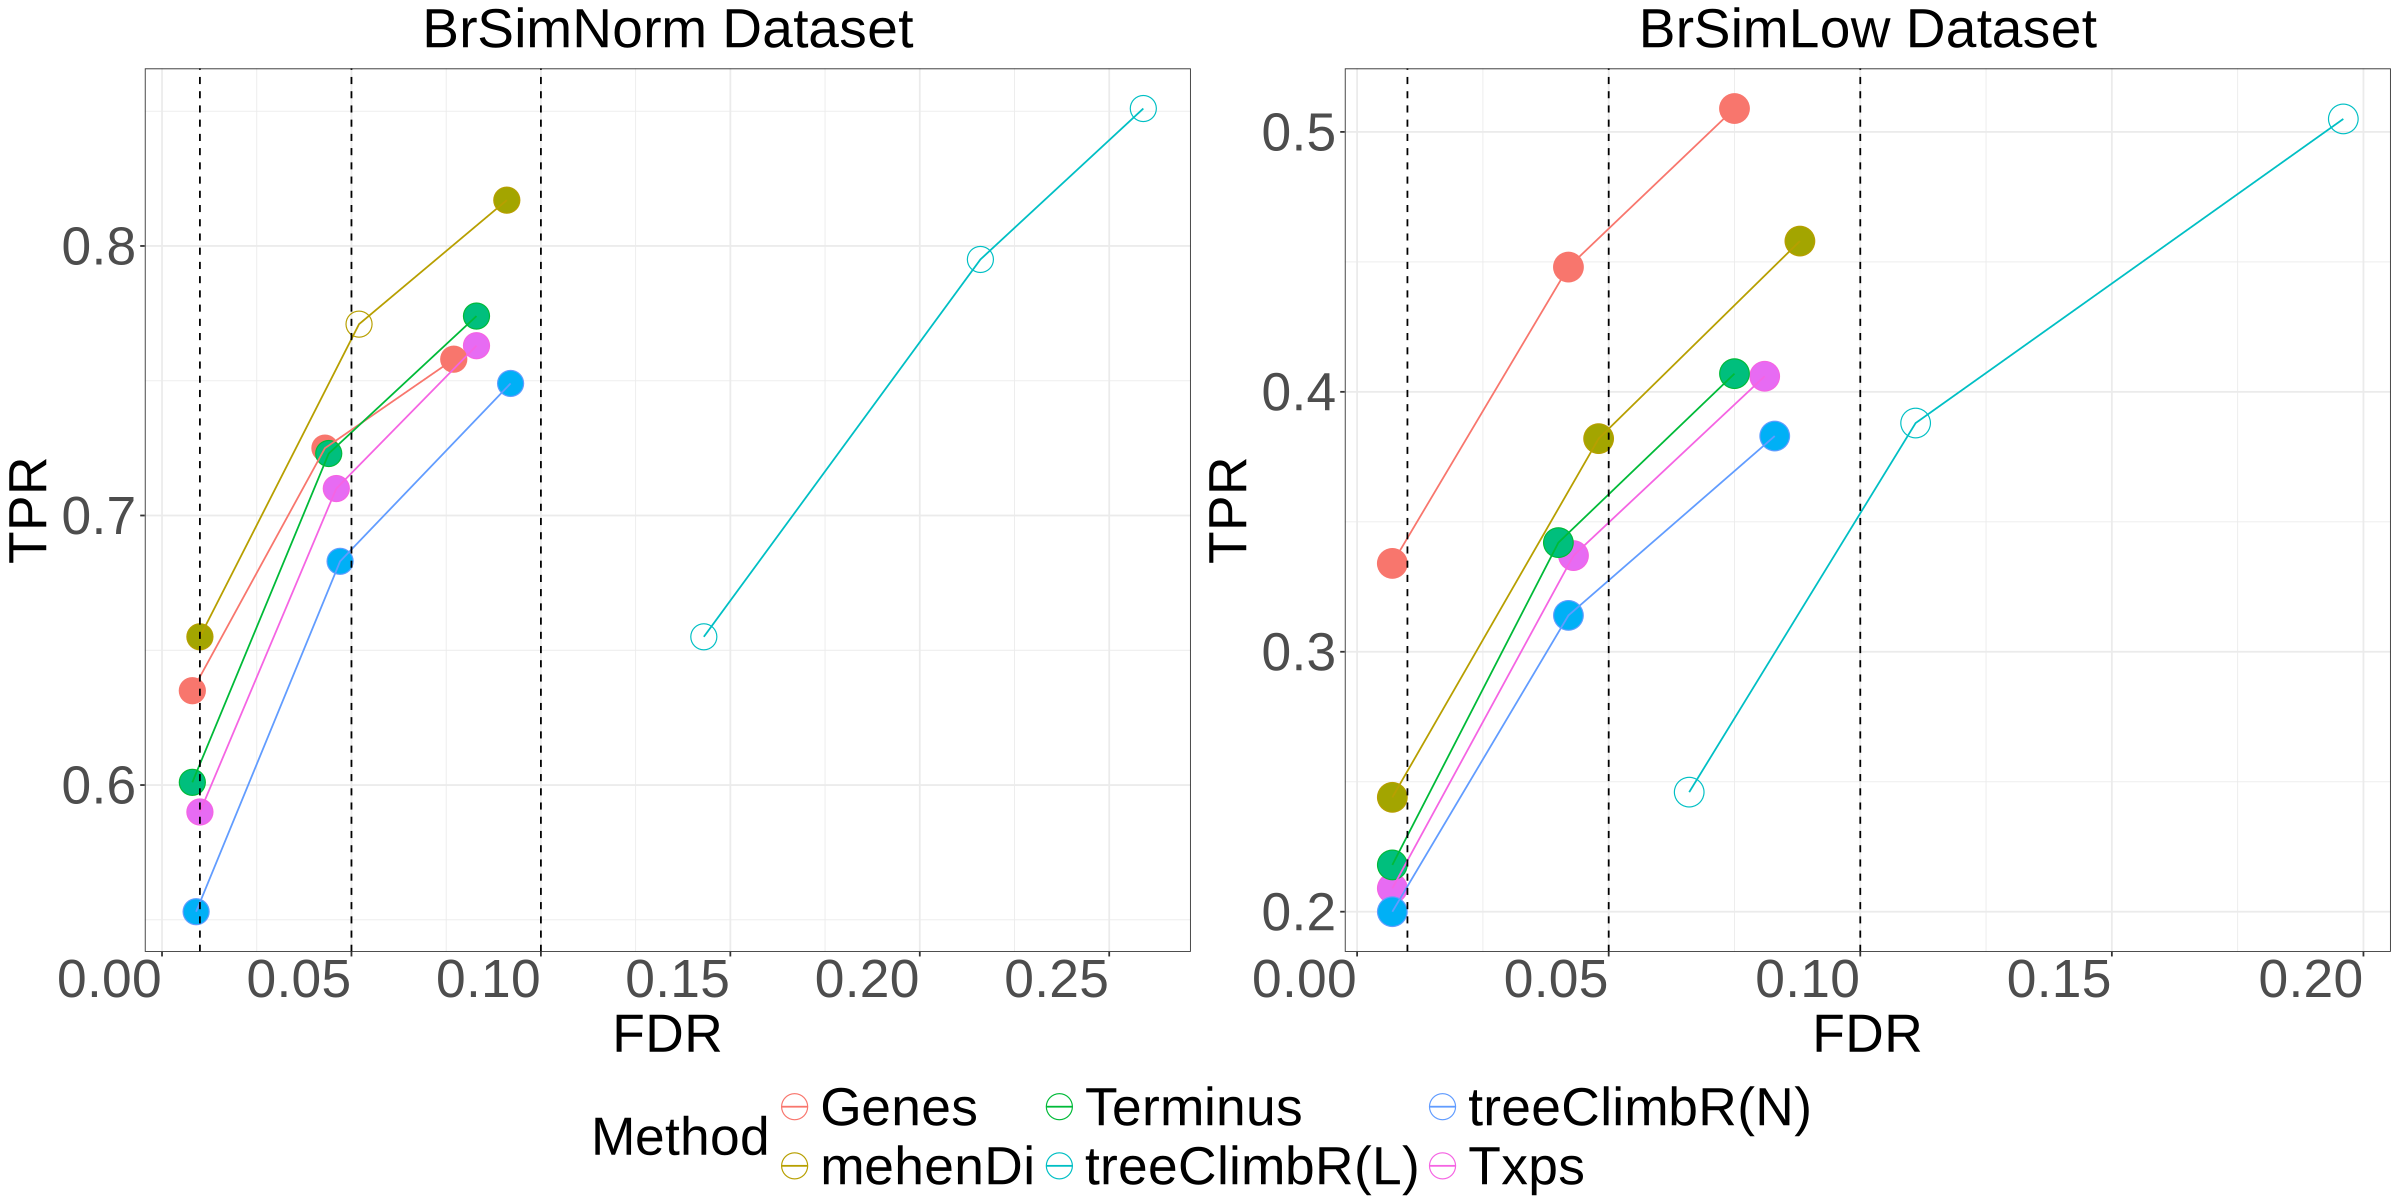

In [106]:
options(repr.plot.width=20, repr.plot.height=10)
load("../../environment/brain_sim_lowfc/pBr.RData")
suppressPackageStartupMessages(library(ggpubr))
pEval <- ggarrange(pBrSimNorm, pBrSimLow, nrow=1, common.legend = T, legend = "bottom")
pEval
ggsave(filename = "../../images/brain_sim/signal/Figure4.pdf", dpi = 600, width = 20, height = 10)

In [9]:
i <- 1
treeDETxps <- rownames(tseCons)[unlist(phangorn::Descendants(treeCons, detNodes[["mehenDi"]][[i]]))]
treeClimbTxps <- rownames(tseCons)[detNodes[["treeClimbR(L)"]][[i]]]

dN <- detNodes[["Terminus"]][[i]]

termTxps <- c(names(logFCNodesTerm)[dN][startsWith(names(logFCNodesTerm)[dN], "ENS")],
  names(logFCNodesTerm)[as.numeric(unlist(groupsClust[names(logFCNodesTerm)[dN][!startsWith(names(logFCNodesTerm)[dN], "ENS")]]))])

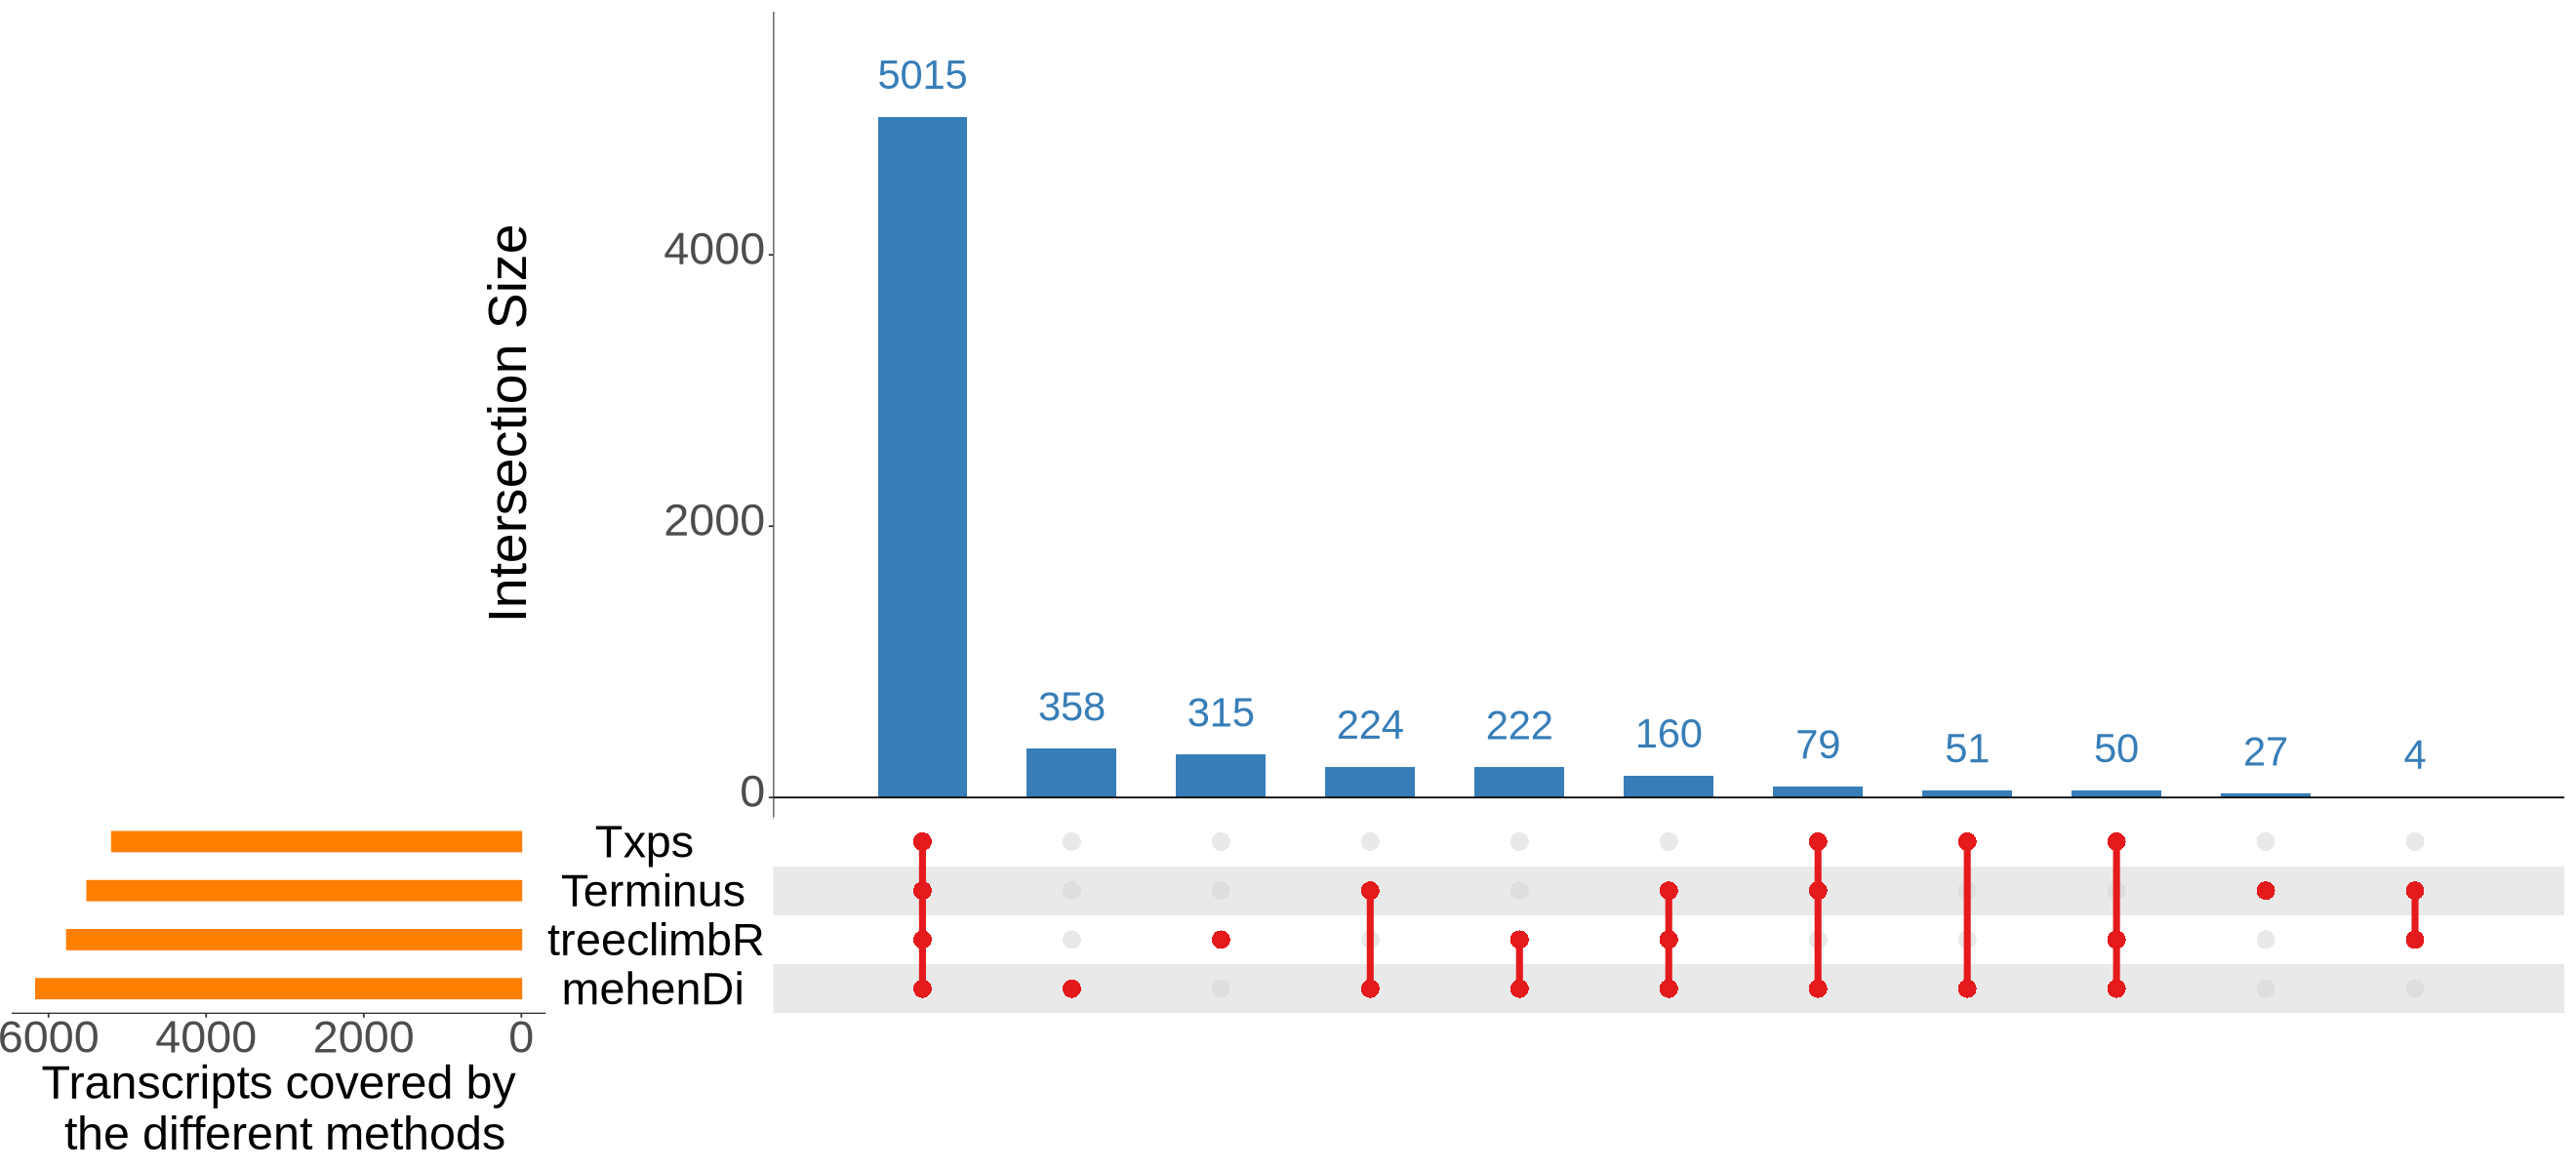

In [10]:
options(repr.plot.width=22, repr.plot.height=10)
suppressPackageStartupMessages(library(UpSetR))
txpMethods = lapply(list(Txps = rownames(tseCons)[detNodes[["Txps"]][[i]]], 
                 mehenDi = treeDETxps, 
                 treeclimbR = treeClimbTxps, 
                 Terminus = termTxps
                 ), function(nodes) intersect(nodes, dts))
upsetData <- fromList(txpMethods)
size <- 4
upset(upsetData, order.by = "freq",
     main.bar.color = "#377eb8", 
     matrix.color = "#e41a1c",
     sets.bar.color = c("#ff7f00"),
     sets.x.label = "Transcripts covered by\n the different methods",
     shade.alpha = 0.7, 
      point.size = 5,
      line.size = 2,
     text.scale = c(size, size, size-0.5, size, size, size)
)

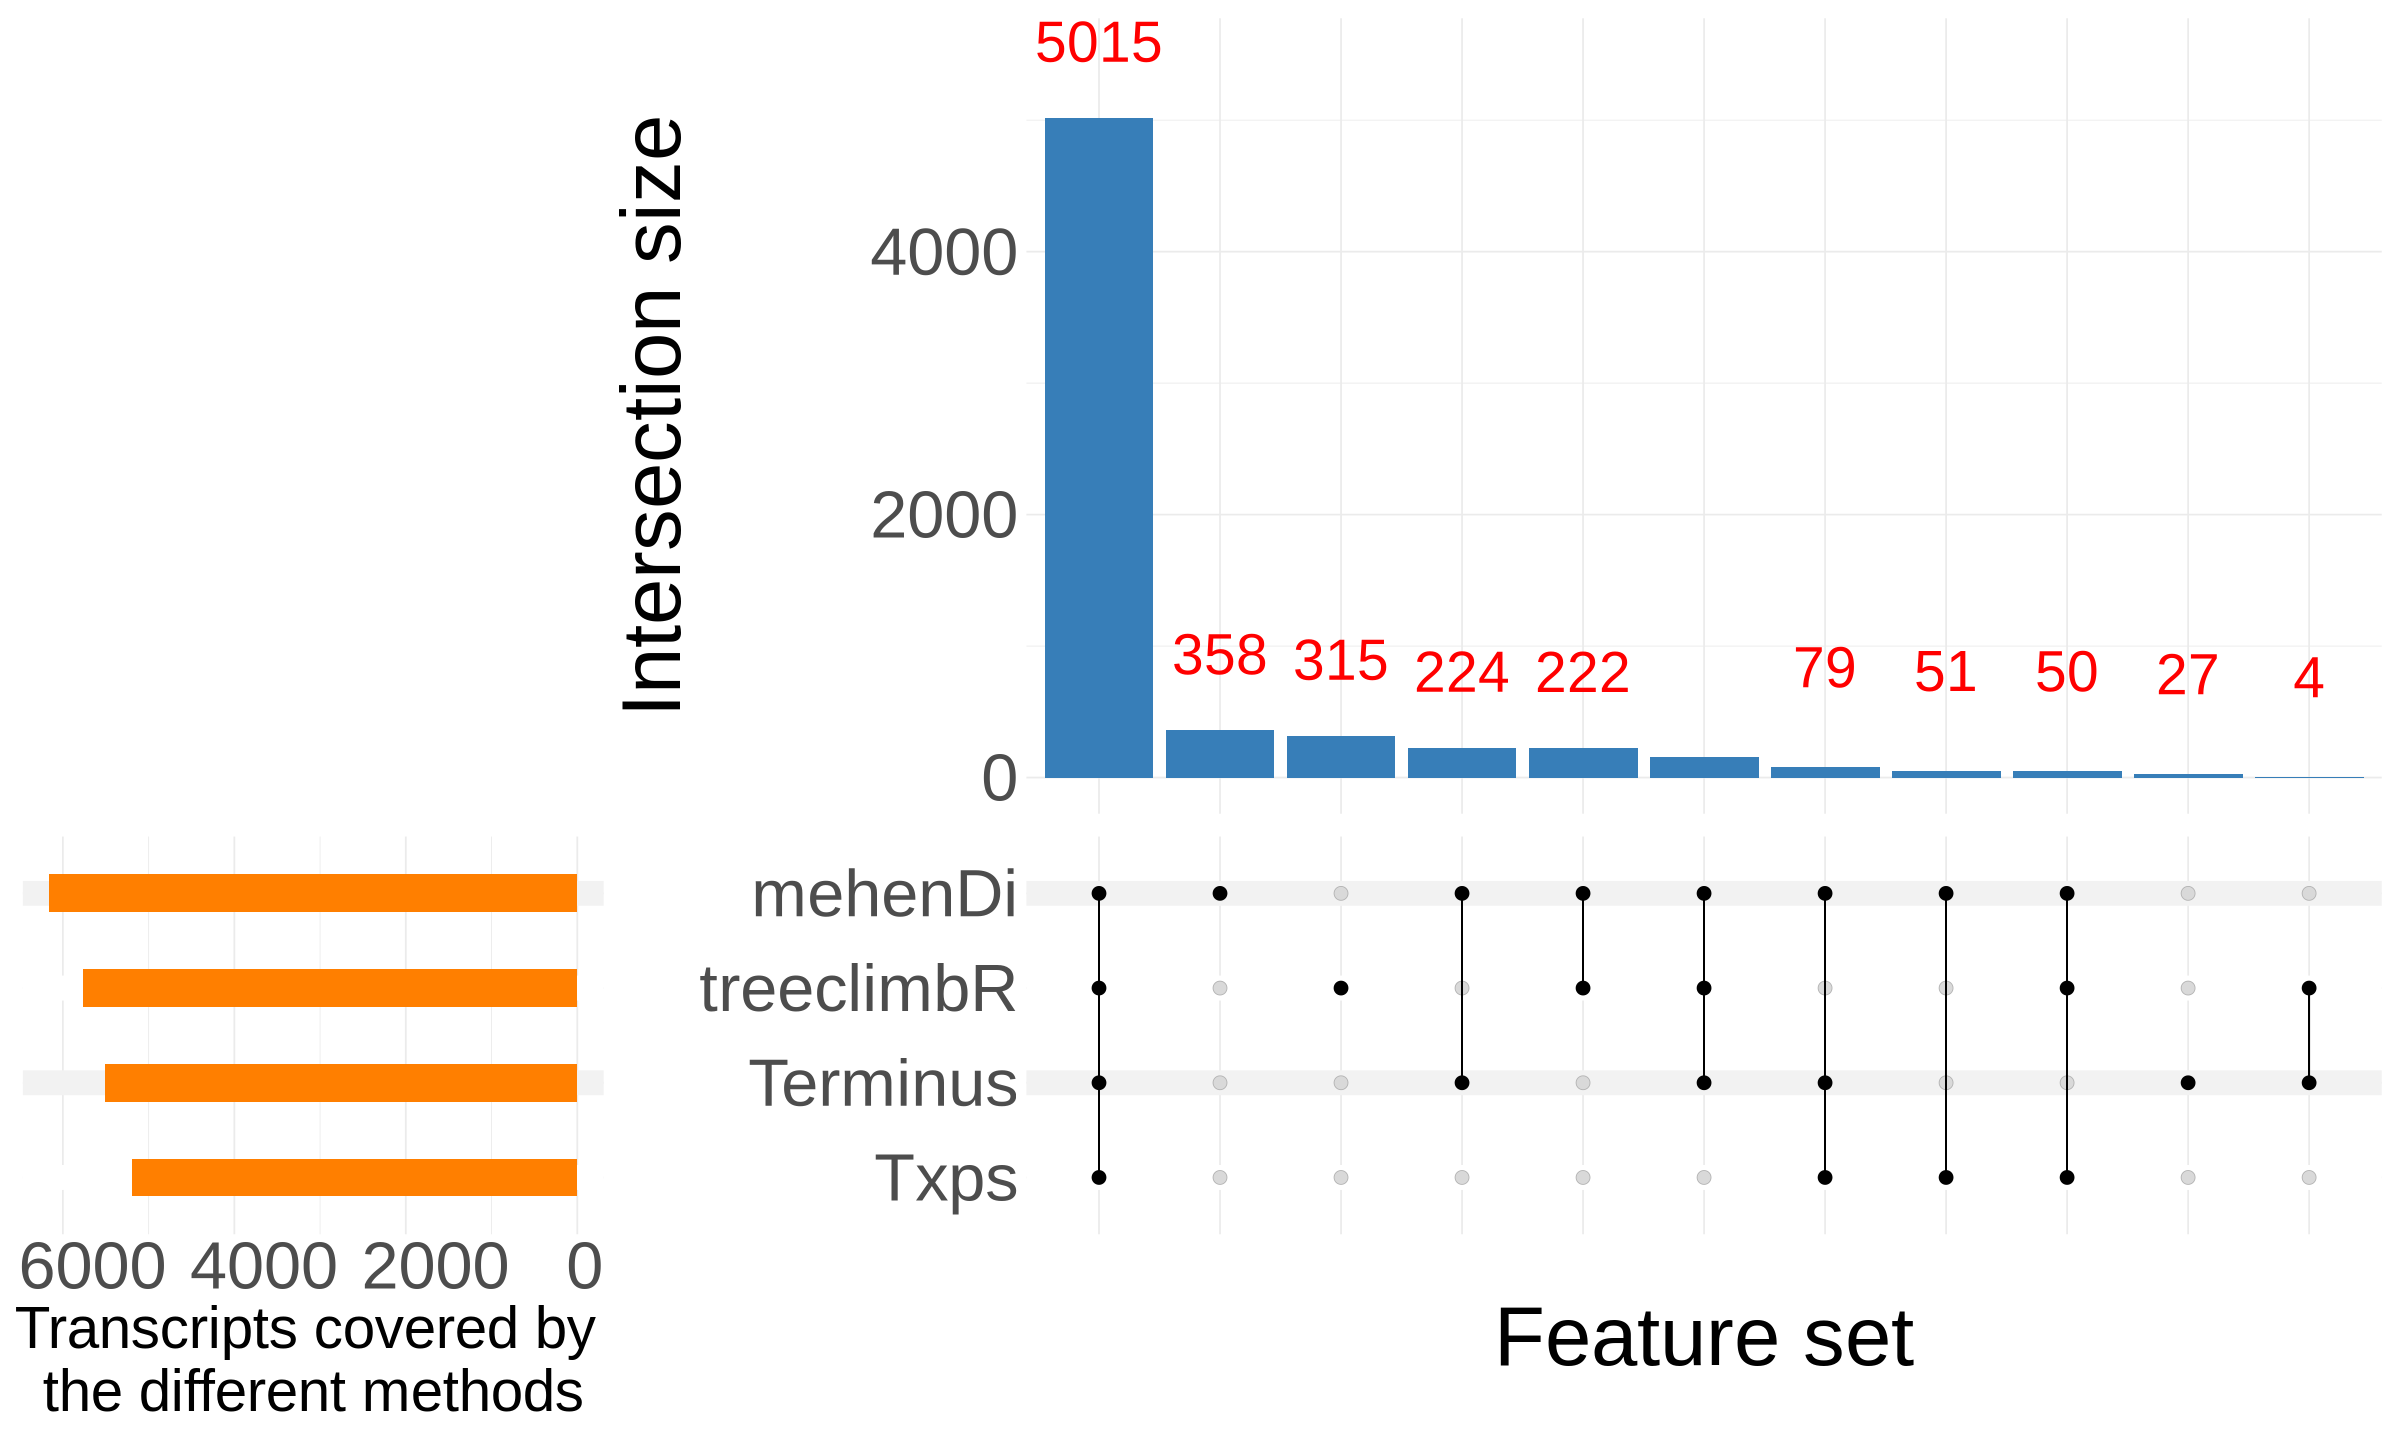

In [32]:
library(ComplexUpset)
library(ggplot2)
options(repr.plot.width=20, repr.plot.height=12)
size = get_size_mode('exclusive_intersection')
ComplexUpset::upset(upsetData, colnames(upsetData), name='Feature set', width_ratio=0.3, min_size=1,
                       base_annotations=list('Intersection size'= intersection_size(
                                               text=list(size=12, 
                                                         vjust=-2),
                                                 mapping=aes(fill="bars_color"),
                                                text_mapping=aes(   
                                                    y=ifelse(!!size> 150, !!size-180, !!size-1)
                                                ),
                                               text_colors=c(on_bar='red',on_background='red')
                                               ) +
                                             ylim(c(0,5500)) + xlab("Transcripts covered") +
                     scale_fill_manual(values=c('bars_color'="#377eb8"), guide='none')
                                             ),
                       themes=upset_default_themes(text=element_text(size=50)),
                        set_sizes=upset_set_size(geom = geom_bar(width=0.4,
                            fill = "#ff7f00"
                        )) +
                             theme(axis.title.x=element_text(size=35),
                                  axis.text.x=element_text(hjust=0.3)) +
                            ylab('Transcripts covered by \nthe different methods')
                   )
